# Name: Aniruddh Kulkarni  
# Roll no: I081          
# Stream: CS (AI)      
# Division: I                         
# Semester: 5th Semester                                           
# Batch: I-3                                                                                      
# Subject: NLP
# Assignment-6

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
import numpy as np
import pandas as pd # to work with csv files
from scipy import sparse

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import TfidfVectorizer

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

# importing required ml model libraries
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Sequential 
from keras.preprocessing.text import Tokenizer

from sklearn import metrics

!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


In [2]:
our_data = pd.read_csv("Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

In [3]:
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/2015 17:48:27,3.0,0.6400,yes,0.640,wsj_398217788,1991-08-14,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/2015 16:54:25,NaN,NaN,no,1.000,wsj_399019502,2007-08-21,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/2015 01:59:03,NaN,NaN,no,1.000,wsj_398284048,1991-11-14,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/2015 02:19:39,NaN,0.0000,no,0.675,wsj_397959018,1986-06-16,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/2015 17:48:27,3.0,0.3257,yes,0.640,wsj_398838054,2002-10-04,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [4]:
our_data.shape # Number of rows (instances) and columns in the dataset

(8000, 15)

In [5]:
our_data["relevance"].unique()

array(['yes', 'no', 'not sure'], dtype=object)

In [6]:
our_data["relevance"].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [7]:
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: count, dtype: float64

In [8]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data.shape

(7991, 15)

In [9]:
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 

In [10]:
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
our_data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,1
7996,"U.S. stocks inched up last week, overcoming co...",0
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,0
7998,The White House's push to contract out many fe...,0


In [11]:
our_data.shape

(7991, 2)

In [12]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pushpakulkarni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc
our_data['text'] = our_data['text'].apply(clean)    

In [14]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews
our_data['text'] = our_data['text'].apply(special_char)

In [15]:
def convert_lower(text):
   return text.lower()
our_data['text'] = our_data['text'].apply(convert_lower)
our_data['text'][1]

'the wall street journal online the morning brief look days biggest news emailed subscribers every business day sign email on friday evening congress town summer recess americans heading midaugust weekend bush administration sent message states the federal government make tougher national childrens insurance program cover offspring middleincome families the state childrens health insurance program created help children whose families couldnt afford insurance didnt qualify medicaid administration officials tell new york times changes aimed returning program low income focus assuring didnt become replacement private insurance administration point man dennis smith wrote state officials saying would new restrictions district columbia states including california new york extend plan extend coverage children whose families make federal poverty levels for family three family four under new limits child family making would spend one year uninsured qualifying state wants extend coverage would a

In [16]:
x = our_data['text']
y = our_data['relevance']
our_data

,text,relevance
0,new york yields certificates deposit offered m...,1
1,the wall street journal online the morning bri...,0
2,washington in effort achieve banking reform se...,0
3,the statistics enormous costs employee drug ab...,0
4,new york indecision marked dollars tone trader...,1
...,...,...
7995,secretary commerce charles w sawyer said yeste...,1
7996,us stocks inched last week overcoming concern ...,0
7997,ben s bernanke cleared key hurdle thursday con...,0
7998,the white houses push contract many federal fu...,0


In [17]:
#BoW 1000 feat
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train1))
print(len(x_test1))

cv = CountVectorizer(max_features = 1000)
x_train1 = cv.fit_transform(x_train1)

x_test1 = cv.transform(x_test1)
print(x_train1.shape, x_test1.shape)

5593
2398
(5593, 1000) (2398, 1000)


In [18]:
#BOW 5000 max feat
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train2))
print(len(x_test2))

cv2 = CountVectorizer(max_features = 5000)
x_train2 = cv2.fit_transform(x_train2)
x_test2 = cv2.transform(x_test2)
print(x_train2.shape, x_test2.shape)

5593
2398
(5593, 5000) (2398, 5000)


In [19]:
#Bag of n gram 1000 feat [bi,tri grams]
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train3))
print(len(x_test3))
count_vect = CountVectorizer(ngram_range=(2,3),max_features = 1000)

x_train3 = count_vect.fit_transform(x_train3)
x_test3 = count_vect.transform(x_test3)
print(x_train3.shape, x_test3.shape)

5593
2398
(5593, 1000) (2398, 1000)


In [20]:
#Bag of n gram 5000 feat [bi,tri grams]
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train4))
print(len(x_test4))
count_vect2 = CountVectorizer(ngram_range=(2,3),max_features = 5000)

x_train4 = count_vect2.fit_transform(x_train4)
x_test4 = count_vect2.transform(x_test4)
print(x_train4.shape, x_test4.shape)

5593
2398
(5593, 5000) (2398, 5000)


In [21]:
#TF-IDF 1000 feat
x_train5, x_test5, y_train5, y_test5 = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train5))
print(len(x_test5))

tfidf = TfidfVectorizer(max_features = 1000)
x_train5 = tfidf.fit_transform(x_train5)
x_test5 = tfidf.fit_transform(x_test5)
print(x_train5.shape, x_test5.shape)

5593
2398
(5593, 1000) (2398, 1000)


In [22]:
#TF-IDF 5000 feat
x_train6, x_test6, y_train6, y_test6 = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train6))
print(len(x_test6))

tfidf2 = TfidfVectorizer(max_features = 5000)
x_train6 = tfidf2.fit_transform(x_train6)
x_test6 = tfidf2.fit_transform(x_test6)
print(x_train6.shape, x_test6.shape)

5593
2398
(5593, 5000) (2398, 5000)


In [23]:
#NORMAL
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1)
vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

n_words1 = x_test1.shape[1]
n_words2 = x_test2.shape[1]
n_words3 = x_test3.shape[1]
n_words4 = x_test4.shape[1]
n_words5 = x_test5.shape[1]
n_words6 = x_test6.shape[1]

In [24]:
#create list of model and accuracy dicts
perform_list1 = [ ]
perform_list2 = [ ]
perform_list3 = [ ]
perform_list4 = [ ]
perform_list5 = [ ]

In [25]:
def run_models(x_train, x_test, y_train, y_test, n_words):

  mdl1=''
  mdl2=''
  mdl3=''
  mdl4=''
  mdl5=''

#Multinomial Naive Bayes
  mdl1 = MultinomialNB(alpha=1.0,fit_prior=True)

#Logistic Regression
  mdl2 = LogisticRegression()

#Support Vector Classifer
  mdl3 = SVC()

#Random Forest
  mdl4 = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)

#ANN
  mdl5 = Sequential()
  mdl5.add(Dense(50, input_shape=(n_words,), activation='relu'))
  #mdl5.add(Dense(50, input_shape=(n_words,), activation='relu'))  #NEWW
  mdl5.add(Dense(1, activation='sigmoid'))
  mdl5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
#---------------------------------------------------------------------------------------------------
  print()
  print("FOR NAIVE BAYES: ")
  print()
  mdl1.fit(x_train, y_train)
  y_pred = mdl1.predict(x_test)
  # Performance metrics

  accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

  # Get precision, recall, f1 scores

  precision, recall, f1score, support = score(y_test, y_pred, average='micro')

  print('Test Accuracy Score of Basic Naive Bayes Model:',accuracy)

  print('Precision :',precision)

  print('Recall :',recall)

  print('F1-score :',f1score)

  #calculate AUC of model
  y_pred_prob = mdl1.predict_proba(x_test)[:, 1]
  auc1 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Naive Bayes: ", auc1)
  

  # Add performance parameters to list

  perform_list1.append(dict([('Model', 'Naive Bayes'),
                            ('Test Accuracy', round(accuracy, 2)),('Precision', round(precision, 2)),('Recall', round(recall, 2)),('F1', round(f1score, 2)),('ROC-AUC', round(auc1, 2))]))
  
#---------------------------------------------------------------------------------------------------
  print()
  print("FOR LOGISTIC REGRESSION: ")
  print()
  mdl2.fit(x_train, y_train)
  y_pred2 = mdl2.predict(x_test)
  # Performance metrics

  accuracy2 = round(accuracy_score(y_test, y_pred2) * 100, 2)

  # Get precision, recall, f1 scores

  precision2, recall2, f1score2, support2 = score(y_test, y_pred2, average='micro')

  print('Test Accuracy Score of Basic Logistic Regression Model:',accuracy2)

  print('Precision :',precision2)

  print('Recall :',recall2)

  print('F1-score :',f1score2)

  #calculate AUC of model
  y_pred_prob = mdl2.predict_proba(x_test)[:, 1]
  auc2 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Logistic Regression: ", auc2)

  # Add performance parameters to list

  perform_list2.append(dict([('Model', 'Logistic Regression'),
                            ('Test Accuracy', round(accuracy2, 2)),('Precision', round(precision2, 2)),('Recall', round(recall2, 2)),('F1', round(f1score2, 2)),('ROC-AUC', round(auc2, 2))]))


#---------------------------------------------------------------------------------------------------

  print()
  print("FOR LINEAR SVC: ")
  print()


  mdl3.fit(x_train, y_train)
  y_pred3 = mdl3.predict(x_test)
  # Performance metrics

  accuracy3 = round(accuracy_score(y_test, y_pred3) * 100, 2)

  # Get precision, recall, f1 scores

  precision3, recall3, f1score3, support3 = score(y_test, y_pred3, average='micro')

  print('Test Accuracy Score of Basic Linear SVC Model:',accuracy3)

  print('Precision :',precision3)

  print('Recall :',recall3)

  print('F1-score :',f1score3)

  #calculate AUC of model
  #y_pred_prob = mdl3.predict_proba(x_test)[:, 1]
  #auc3 = metrics.roc_auc_score(y_test, y_pred_prob)
  #print("ROC_AOC_Score for Linear SVC: ", auc3)

  # Add performance parameters to list

  perform_list3.append(dict([('Model', 'Linear SVC'),
                            ('Test Accuracy', round(accuracy3, 2)),('Precision', round(precision3, 2)),('Recall', round(recall3, 2)),('F1', round(f1score3, 2))]))


#---------------------------------------------------------------------------------------------------


  print()
  print("FOR RANDOM FOREST: ")
  print()
  mdl4.fit(x_train, y_train)
  y_pred4 = mdl4.predict(x_test)
  # Performance metrics

  accuracy4 = round(accuracy_score(y_test, y_pred4) * 100, 2)



  # Get precision, recall, f1 scores

  precision4, recall4, f1score4, support4 = score(y_test, y_pred4, average='micro')

  print('Test Accuracy Score of Basic Random Forest Model:',accuracy4)

  print('Precision :',precision4)

  print('Recall :',recall4)

  print('F1-score :',f1score4)

  #calculate AUC of model
  y_pred_prob = mdl4.predict_proba(x_test)[:, 1]
  auc4 = metrics.roc_auc_score(y_test, y_pred_prob)
  print("ROC_AOC_Score for Random Forest: ", auc4)



  # Add performance parameters to list

  perform_list4.append(dict([('Model', 'Random Forest'),
                            ('Test Accuracy', round(accuracy4, 2)),('Precision', round(precision4, 2)),('Recall', round(recall4, 2)),('F1', round(f1score4, 2)),('ROC-AUC', round(auc4, 2))]))



#---------------------------------------------------------------------------------------------------

  print()
  print("FOR ANN: ")
  print()
  mdl5.summary()
  x_train = x_train.toarray()
  y_train = np.array(y_train)
  x_test = x_test.toarray()
  y_test = np.array(y_test)
  mdl5.fit(x_train, y_train, epochs=69, verbose=2)  #SAME
  loss, acc = mdl5.evaluate(x_test, y_test, verbose=0)
  #calculate AUC of model
  #y_pred_prob = mdl5.predict_proba(x_test)[:, 1]
  #auc5 = metrics.roc_auc_score(y_test, y_pred_prob)
  #print("ROC_AOC_Score for ANN: ", auc5)
  print('Test Accuracy:',acc)
  perform_list5.append(dict([('Model', 'ANN'),('Test Accuracy', round(acc, 2)),('Loss',round(loss,2))]))
                            


In [26]:
#BoW 1000 feat
run_models(x_train1, x_test1, y_train1, y_test1, n_words1)

Metal device set to: Apple M1

FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.64
Precision : 0.6763969974979149
Recall : 0.6763969974979149
F1-score : 0.6763969974979149
ROC_AOC_Score for Naive Bayes:  0.7230764847947851

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 77.31
Precision : 0.7731442869057548
Recall : 0.7731442869057548
F1-score : 0.7731442869057548
ROC_AOC_Score for Logistic Regression:  0.6721538695885237

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.44
Precision : 0.8144286905754796
Recall : 0.8144286905754796
F1-score : 0.8144286905754796
ROC_AOC_Score for Random Forest:  0.7156962608183014

FOR ANN: 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Sha

2023-05-28 00:56:58.047999: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


175/175 - 4s - loss: 0.4473 - accuracy: 0.8196 - 4s/epoch - 21ms/step
Epoch 2/69
175/175 - 1s - loss: 0.3668 - accuracy: 0.8453 - 1s/epoch - 8ms/step
Epoch 3/69
175/175 - 1s - loss: 0.3106 - accuracy: 0.8714 - 1s/epoch - 8ms/step
Epoch 4/69
175/175 - 1s - loss: 0.2504 - accuracy: 0.9054 - 1s/epoch - 7ms/step
Epoch 5/69
175/175 - 1s - loss: 0.1902 - accuracy: 0.9374 - 1s/epoch - 8ms/step
Epoch 6/69
175/175 - 1s - loss: 0.1391 - accuracy: 0.9623 - 1s/epoch - 7ms/step
Epoch 7/69
175/175 - 1s - loss: 0.0960 - accuracy: 0.9832 - 1s/epoch - 8ms/step
Epoch 8/69
175/175 - 2s - loss: 0.0660 - accuracy: 0.9903 - 2s/epoch - 9ms/step
Epoch 9/69
175/175 - 1s - loss: 0.0456 - accuracy: 0.9959 - 1s/epoch - 8ms/step
Epoch 10/69
175/175 - 1s - loss: 0.0321 - accuracy: 0.9980 - 1s/epoch - 8ms/step
Epoch 11/69
175/175 - 2s - loss: 0.0240 - accuracy: 0.9979 - 2s/epoch - 9ms/step
Epoch 12/69
175/175 - 1s - loss: 0.0184 - accuracy: 0.9982 - 1s/epoch - 9ms/step
Epoch 13/69
175/175 - 1s - loss: 0.0142 - accur

In [27]:
#BoW 5000 feat
run_models(x_train2, x_test2, y_train2, y_test2, n_words2)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.18
Precision : 0.6718098415346122
Recall : 0.6718098415346122
F1-score : 0.6718098415346122
ROC_AOC_Score for Naive Bayes:  0.7333456589003966

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 76.27
Precision : 0.762718932443703
Recall : 0.762718932443703
F1-score : 0.7627189324437029
ROC_AOC_Score for Logistic Regression:  0.6668678292234544

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078
ROC_AOC_Score for Random Forest:  0.7065078994094194

FOR ANN: 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dens

In [28]:
#Bag of n grams 1000 feat [bi,tri grams]
run_models(x_train3, x_test3, y_train3, y_test3, n_words3)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 76.36
Precision : 0.7635529608006673
Recall : 0.7635529608006673
F1-score : 0.7635529608006673
ROC_AOC_Score for Naive Bayes:  0.6754207262549694

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 79.73
Precision : 0.7973311092577148
Recall : 0.7973311092577148
F1-score : 0.7973311092577148
ROC_AOC_Score for Logistic Regression:  0.6465835504842437

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.86
Precision : 0.8185988323603003
Recall : 0.8185988323603003
F1-score : 0.8185988323603003

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Random Forest:  0.7150526569155151

FOR ANN: 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 den

In [29]:
#Bag of n grams 5000 feat [bi,tri grams]
run_models(x_train4, x_test4, y_train4, y_test4, n_words4)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 75.73
Precision : 0.7572977481234362
Recall : 0.7572977481234362
F1-score : 0.7572977481234362
ROC_AOC_Score for Naive Bayes:  0.6868817594398147

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 78.27
Precision : 0.7827356130108424
Recall : 0.7827356130108424
F1-score : 0.7827356130108424
ROC_AOC_Score for Logistic Regression:  0.6406934410541383

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078
ROC_AOC_Score for Random Forest:  0.7019695325935668

FOR ANN: 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de

In [30]:
#TF-IDF 1000 feat
run_models(x_train5, x_test5, y_train5, y_test5, n_words5)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Naive Bayes:  0.5571260963650043

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Logistic Regression:  0.5745935179145141

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Random Forest:  0.5970522127299852

FOR ANN: 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Den

In [31]:
#TF-IDF 5000 feat
run_models(x_train6, x_test6, y_train6, y_test6, n_words6)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 80.15
Precision : 0.8015012510425354
Recall : 0.8015012510425354
F1-score : 0.8015012510425356
ROC_AOC_Score for Naive Bayes:  0.5291551986567458

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Logistic Regression:  0.547886572224916

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Random Forest:  0.5820696720120093

FOR ANN: 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (

In [88]:
perform_list = perform_list1 + perform_list2 + perform_list3 + perform_list4 + perform_list5 
model_performance_I = pd.DataFrame(data=perform_list)
model_performance_I = model_performance_I[['Model', 'Test Accuracy', 'ROC-AUC', 'Loss', 'Precision', 'Recall', 'F1']]
model_performance_I

,Model,Test Accuracy,ROC-AUC,Loss,Precision,Recall,F1
0,Naive Bayes,67.76,0.72,NaN,0.68,0.68,0.68
1,Naive Bayes,67.26,0.73,NaN,0.67,0.67,0.67
2,Naive Bayes,76.65,0.68,NaN,0.77,0.77,0.77
3,Naive Bayes,75.65,0.69,NaN,0.76,0.76,0.76
4,Naive Bayes,82.19,0.73,NaN,0.82,0.82,0.82
5,Naive Bayes,81.78,0.72,NaN,0.82,0.82,0.82
6,Naive Bayes,66.96,0.73,NaN,0.67,0.67,0.67
7,Naive Bayes,68.50,0.74,NaN,0.69,0.69,0.69
8,Naive Bayes,66.86,0.68,NaN,0.67,0.67,0.67
9,Naive Bayes,66.57,0.70,NaN,0.67,0.67,0.67


# CLASS BALANCING

In [33]:
our_data["relevance"].value_counts()

relevance
0    6571
1    1420
Name: count, dtype: int64

In [34]:
our_data.isnull().sum()

text         0
relevance    0
dtype: int64

In [35]:
#NO SAMPLING_BoW 1000 feat

x8 = np.array(our_data.iloc[:,0].values)
y8 = np.array(our_data.relevance.values)

counter = Counter(y8)
print('Count: ',counter)

#BoW 1000 feat
x8 = cv.fit_transform(our_data.text).toarray()

x_train8, x_test8, y_train8, y_test8 = train_test_split(x8, y8, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train8))
print(len(x_test8))

x_train8=sparse.csr_matrix(x_train8)
x_test8=sparse.csr_matrix(x_test8)
print(x_train8.shape, x_test8.shape)


Count:  Counter({0: 6571, 1: 1420})
5593
2398
(5593, 1000) (2398, 1000)


In [36]:
#NO SAMPLING_BoW 5000 feat

x9 = np.array(our_data.iloc[:,0].values)
y9 = np.array(our_data.relevance.values)

counter = Counter(y9)
print('Count: ',counter)

x9 = cv2.fit_transform(our_data.text).toarray()

x_train9, x_test9, y_train9, y_test9 = train_test_split(x9, y9, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train9))
print(len(x_test9))

x_train9=sparse.csr_matrix(x_train9)
x_test9=sparse.csr_matrix(x_test9)
print(x_train9.shape, x_test9.shape)

Count:  Counter({0: 6571, 1: 1420})
5593
2398
(5593, 5000) (2398, 5000)


In [37]:
#NO SAMPLING_Bag of n grams 1000 feat [bi,tri grams]

x10 = np.array(our_data.iloc[:,0].values)
y10 = np.array(our_data.relevance.values)

counter = Counter(y10)
print('Count: ',counter)


x10 = count_vect.fit_transform(our_data.text).toarray()

x_train10, x_test10, y_train10, y_test10 = train_test_split(x10, y10, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train10))
print(len(x_test10))

x_train10=sparse.csr_matrix(x_train10)
x_test10=sparse.csr_matrix(x_test10)
print(x_train10.shape, x_test10.shape)

Count:  Counter({0: 6571, 1: 1420})
5593
2398
(5593, 1000) (2398, 1000)


In [38]:
#NO SAMPLING_Bag of n grams 5000 feat [bi,tri grams]

x11 = np.array(our_data.iloc[:,0].values)
y11 = np.array(our_data.relevance.values)

counter = Counter(y11)
print('Count: ',counter)


x11 = count_vect2.fit_transform(our_data.text).toarray()

x_train11, x_test11, y_train11, y_test11 = train_test_split(x11, y11, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train11))
print(len(x_test11))

x_train11=sparse.csr_matrix(x_train11)
x_test11=sparse.csr_matrix(x_test11)
print(x_train11.shape, x_test11.shape)

Count:  Counter({0: 6571, 1: 1420})
5593
2398
(5593, 5000) (2398, 5000)


In [39]:
#NO SAMPLING_Tf-Idf 1000 feat

x12 = np.array(our_data.iloc[:,0].values)
y12 = np.array(our_data.relevance.values)

counter = Counter(y12)
print('Count: ',counter)


x12 = tfidf.fit_transform(our_data.text).toarray()

x_train12, x_test12, y_train12, y_test12 = train_test_split(x12, y12, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train12))
print(len(x_test12))

x_train12=sparse.csr_matrix(x_train12)
x_test12=sparse.csr_matrix(x_test12)
print(x_train12.shape, x_test12.shape)

Count:  Counter({0: 6571, 1: 1420})
5593
2398
(5593, 1000) (2398, 1000)


In [40]:
#NO SAMPLING_Tf-Idf 5000 feat 

x13 = np.array(our_data.iloc[:,0].values)
y13 = np.array(our_data.relevance.values)

counter = Counter(y13)
print('Count: ',counter)

x13 = tfidf2.fit_transform(our_data.text).toarray()

x_train13, x_test13, y_train13, y_test13 = train_test_split(x13, y13, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train13))
print(len(x_test13))

x_train13=sparse.csr_matrix(x_train13)
x_test13=sparse.csr_matrix(x_test13)
print(x_train13.shape, x_test13.shape)

Count:  Counter({0: 6571, 1: 1420})
5593
2398
(5593, 5000) (2398, 5000)


In [41]:
#Under Sampling_BoW 1000 feat

x14 = np.array(our_data.iloc[:,0].values)
y14 = np.array(our_data.relevance.values)

counter = Counter(y14)
print('Before Under Sampling: ',counter)

x14 = cv.fit_transform(our_data.text).toarray()
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x14, y14 = undersample.fit_resample(x14, y14)

x_train14, x_test14, y_train14, y_test14 = train_test_split(x14, y14, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train14))
print(len(x_test14))

counter = Counter(y14)
print('After Under Sampling: ',counter)
x_train14=sparse.csr_matrix(x_train14)
x_test14=sparse.csr_matrix(x_test14)
print(x_train14.shape, x_test14.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
2413
1035
After Under Sampling:  Counter({0: 2028, 1: 1420})
(2413, 1000) (1035, 1000)


In [42]:
#Under Sampling_BoW 5000 feat

x15 = np.array(our_data.iloc[:,0].values)
y15 = np.array(our_data.relevance.values)

counter = Counter(y15)
print('Before Under Sampling: ',counter)

x15 = cv2.fit_transform(our_data.text).toarray()
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x15, y15 = undersample.fit_resample(x15, y15)

x_train15, x_test15, y_train15, y_test15 = train_test_split(x15, y15, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train15))
print(len(x_test15))

counter = Counter(y15)
print('After Under Sampling: ',counter)
x_train15=sparse.csr_matrix(x_train15)
x_test15=sparse.csr_matrix(x_test15)
print(x_train15.shape, x_test15.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
2413
1035
After Under Sampling:  Counter({0: 2028, 1: 1420})
(2413, 5000) (1035, 5000)


In [43]:
#Under Sampling_Bag of n grams 1000 feat

x16 = np.array(our_data.iloc[:,0].values)
y16 = np.array(our_data.relevance.values)

counter = Counter(y16)
print('Before Under Sampling: ',counter)

x16 = count_vect.fit_transform(our_data.text).toarray()
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x16, y16 = undersample.fit_resample(x16, y16)

x_train16, x_test16, y_train16, y_test16 = train_test_split(x16, y16, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train16))
print(len(x_test16))

counter = Counter(y16)
print('After Under Sampling: ',counter)
x_train16=sparse.csr_matrix(x_train16)
x_test16=sparse.csr_matrix(x_test16)
print(x_train16.shape, x_test16.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
2413
1035
After Under Sampling:  Counter({0: 2028, 1: 1420})
(2413, 1000) (1035, 1000)


In [44]:
#Under Sampling_Bag of n grams 5000 feat

x17 = np.array(our_data.iloc[:,0].values)
y17 = np.array(our_data.relevance.values)

counter = Counter(y17)
print('Before Under Sampling: ',counter)

x17 = count_vect2.fit_transform(our_data.text).toarray()
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x17, y17 = undersample.fit_resample(x17, y17)

x_train17, x_test17, y_train17, y_test17 = train_test_split(x17, y17, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train17))
print(len(x_test17))

counter = Counter(y17)
print('After Under Sampling: ',counter)
x_train17=sparse.csr_matrix(x_train17)
x_test17=sparse.csr_matrix(x_test17)
print(x_train17.shape, x_test17.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
2413
1035
After Under Sampling:  Counter({0: 2028, 1: 1420})
(2413, 5000) (1035, 5000)


In [45]:
#Under Sampling_TF-IDF 1000 feat

x18 = np.array(our_data.iloc[:,0].values)
y18 = np.array(our_data.relevance.values)

counter = Counter(y18)
print('Before Under Sampling: ',counter)

x18 = tfidf.fit_transform(our_data.text).toarray()
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x18, y18 = undersample.fit_resample(x18, y18)

x_train18, x_test18, y_train18, y_test18 = train_test_split(x18, y18, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train18))
print(len(x_test18))

counter = Counter(y18)
print('After Under Sampling: ',counter)
x_train18=sparse.csr_matrix(x_train18)
x_test18=sparse.csr_matrix(x_test18)
print(x_train18.shape, x_test18.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
2413
1035
After Under Sampling:  Counter({0: 2028, 1: 1420})
(2413, 1000) (1035, 1000)


In [46]:
#Under Sampling_TF-IDF 5000 feat

x19 = np.array(our_data.iloc[:,0].values)
y19 = np.array(our_data.relevance.values)

counter = Counter(y19)
print('Before Under Sampling: ',counter)

x19 = tfidf2.fit_transform(our_data.text).toarray()
# Undersampling
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x19, y19 = undersample.fit_resample(x19, y19)

x_train19, x_test19, y_train19, y_test19 = train_test_split(x19, y19, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train19))
print(len(x_test19))

counter = Counter(y19)
print('After Under Sampling: ',counter)
x_train19=sparse.csr_matrix(x_train19)
x_test19=sparse.csr_matrix(x_test19)
print(x_train19.shape, x_test19.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
2413
1035
After Under Sampling:  Counter({0: 2028, 1: 1420})
(2413, 5000) (1035, 5000)


In [47]:
#Under Sampling_I (text)
'''
x9 = x
y9 = y

counter = Counter(y9)
print('Before Under Sampling: ',counter)

# transform the dataset
undersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW
x9=np.array(x9)
x9=x9.reshape(-1, 1)
x9, y9 = undersample.fit_resample(x9, y9)
x9=x9.reshape(-1)
x9=pd.Series(x9)
counter = Counter(y9)
print('After Under Sampling: ',counter)



#BoW 1000 feat
x_train9, x_test9, y_train9, y_test9 = train_test_split(x9, y9, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train9))
print(len(x_test9))

cv = CountVectorizer(max_features = 1000)
x_train9 = cv.fit_transform(x_train9)

x_test9 = cv.transform(x_test9)
print(x_train9.shape, x_test9.shape)   '''

"\nx9 = x\ny9 = y\n\ncounter = Counter(y9)\nprint('Before Under Sampling: ',counter)\n\n# transform the dataset\nundersample = RandomUnderSampler(sampling_strategy=0.7)  #current sample in minority/0.5 = updated samples in majority class NEW\nx9=np.array(x9)\nx9=x9.reshape(-1, 1)\nx9, y9 = undersample.fit_resample(x9, y9)\nx9=x9.reshape(-1)\nx9=pd.Series(x9)\ncounter = Counter(y9)\nprint('After Under Sampling: ',counter)\n\n\n\n#BoW 1000 feat\nx_train9, x_test9, y_train9, y_test9 = train_test_split(x9, y9, test_size = 0.3, random_state = 0, shuffle = True)\nprint(len(x_train9))\nprint(len(x_test9))\n\ncv = CountVectorizer(max_features = 1000)\nx_train9 = cv.fit_transform(x_train9)\n\nx_test9 = cv.transform(x_test9)\nprint(x_train9.shape, x_test9.shape)   "

In [48]:
#Over Sampling_BoW 1000 feat

x20 = np.array(our_data.iloc[:,0].values)
y20 = np.array(our_data.relevance.values)

counter = Counter(y20)
print('Before Under Sampling: ',counter)

x20 = cv.fit_transform(our_data.text).toarray()
# Oversampling
oversample = RandomOverSampler(sampling_strategy=0.7)   #0.5 * majority class = updates sample count in minority  NEW
x20, y20 = oversample.fit_resample(x20, y20)

x_train20, x_test20, y_train20, y_test20 = train_test_split(x20, y20, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train20))
print(len(x_test20))

counter = Counter(y20)
print('After Under Sampling: ',counter)
x_train20=sparse.csr_matrix(x_train20)
x_test20=sparse.csr_matrix(x_test20)
print(x_train20.shape, x_test20.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 1000) (3351, 1000)


In [49]:
#Over Sampling_BoW 5000 feat

x21 = np.array(our_data.iloc[:,0].values)
y21 = np.array(our_data.relevance.values)

counter = Counter(y21)
print('Before Under Sampling: ',counter)

x21 = cv2.fit_transform(our_data.text).toarray()
# Oversampling
oversample = RandomOverSampler(sampling_strategy=0.7)   #0.5 * majority class = updates sample count in minority  NEW
x21, y21 = oversample.fit_resample(x21, y21)

x_train21, x_test21, y_train21, y_test21 = train_test_split(x21, y21, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train21))
print(len(x_test21))

counter = Counter(y21)
print('After Under Sampling: ',counter)
x_train21=sparse.csr_matrix(x_train21)
x_test21=sparse.csr_matrix(x_test21)
print(x_train21.shape, x_test21.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 5000) (3351, 5000)


In [50]:
#Over Sampling_Bag of n grams 1000 feat [bi,tri grams]

x22 = np.array(our_data.iloc[:,0].values)
y22 = np.array(our_data.relevance.values)

counter = Counter(y22)
print('Before Under Sampling: ',counter)

x22 = count_vect.fit_transform(our_data.text).toarray()
# Oversampling
oversample = RandomOverSampler(sampling_strategy=0.7)   #0.5 * majority class = updates sample count in minority  NEW
x22, y22 = oversample.fit_resample(x22, y22)

x_train22, x_test22, y_train22, y_test22 = train_test_split(x22, y22, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train22))
print(len(x_test22))

counter = Counter(y22)
print('After Under Sampling: ',counter)
x_train22=sparse.csr_matrix(x_train22)
x_test22=sparse.csr_matrix(x_test22)
print(x_train22.shape, x_test22.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 1000) (3351, 1000)


In [51]:
#Over Sampling_Bag of n grams 5000 feat [bi,tri grams]

x23 = np.array(our_data.iloc[:,0].values)
y23 = np.array(our_data.relevance.values)

counter = Counter(y23)
print('Before Under Sampling: ',counter)

x23 = count_vect2.fit_transform(our_data.text).toarray()
# Oversampling
oversample = RandomOverSampler(sampling_strategy=0.7)   #0.5 * majority class = updates sample count in minority  NEW
x23, y23 = oversample.fit_resample(x23, y23)

x_train23, x_test23, y_train23, y_test23 = train_test_split(x23, y23, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train23))
print(len(x_test23))

counter = Counter(y23)
print('After Under Sampling: ',counter)
x_train23=sparse.csr_matrix(x_train23)
x_test23=sparse.csr_matrix(x_test23)
print(x_train23.shape, x_test23.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 5000) (3351, 5000)


In [52]:
#Over Sampling_TF-IDF 1000 feat 

x24 = np.array(our_data.iloc[:,0].values)
y24 = np.array(our_data.relevance.values)

counter = Counter(y24)
print('Before Under Sampling: ',counter)

x24 = tfidf.fit_transform(our_data.text).toarray()
# Oversampling
oversample = RandomOverSampler(sampling_strategy=0.7)   #0.5 * majority class = updates sample count in minority  NEW
x24, y24 = oversample.fit_resample(x24, y24)

x_train24, x_test24, y_train24, y_test24 = train_test_split(x24, y24, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train24))
print(len(x_test24))

counter = Counter(y24)
print('After Under Sampling: ',counter)
x_train24=sparse.csr_matrix(x_train24)
x_test24=sparse.csr_matrix(x_test24)
print(x_train24.shape, x_test24.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 1000) (3351, 1000)


In [53]:
#Over Sampling_TF-IDF 5000 feat 

x25 = np.array(our_data.iloc[:,0].values)
y25 = np.array(our_data.relevance.values)

counter = Counter(y25)
print('Before Under Sampling: ',counter)

x25 = tfidf2.fit_transform(our_data.text).toarray()
# Oversampling
oversample = RandomOverSampler(sampling_strategy=0.7)   #0.5 * majority class = updates sample count in minority  NEW
x25, y25 = oversample.fit_resample(x25, y25)

x_train25, x_test25, y_train25, y_test25 = train_test_split(x25, y25, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train25))
print(len(x_test25))

counter = Counter(y25)
print('After Under Sampling: ',counter)
x_train25=sparse.csr_matrix(x_train25)
x_test25=sparse.csr_matrix(x_test25)
print(x_train25.shape, x_test25.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 5000) (3351, 5000)


In [54]:
#SMOTE BoW 1000 feat

x26 = np.array(our_data.iloc[:,0].values)
y26 = np.array(our_data.relevance.values)

counter = Counter(y26)
print('Before Under Sampling: ',counter)

x26 = cv.fit_transform(our_data.text).toarray()
# SMOTE
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x26, y26 = smote.fit_resample(x26, y26)

x_train26, x_test26, y_train26, y_test26 = train_test_split(x26, y26, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train26))
print(len(x_test26))

counter = Counter(y26)
print('After Under Sampling: ',counter)
x_train26=sparse.csr_matrix(x_train26)
x_test26=sparse.csr_matrix(x_test26)
print(x_train26.shape, x_test26.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 1000) (3351, 1000)


In [55]:
#SMOTE BoW 5000 feat

x27 = np.array(our_data.iloc[:,0].values)
y27 = np.array(our_data.relevance.values)

counter = Counter(y27)
print('Before Under Sampling: ',counter)

x27 = cv2.fit_transform(our_data.text).toarray()
# SMOTE
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x27, y27 = smote.fit_resample(x27, y27)

x_train27, x_test27, y_train27, y_test27 = train_test_split(x27, y27, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train27))
print(len(x_test27))

counter = Counter(y27)
print('After Under Sampling: ',counter)
x_train27=sparse.csr_matrix(x_train27)
x_test27=sparse.csr_matrix(x_test27)
print(x_train27.shape, x_test27.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 5000) (3351, 5000)


In [56]:
#SMOTE Bag of n grams 1000 feat [bi,tri grams]

x28 = np.array(our_data.iloc[:,0].values)
y28 = np.array(our_data.relevance.values)

counter = Counter(y28)
print('Before Under Sampling: ',counter)

x28 = count_vect.fit_transform(our_data.text).toarray()
# SMOTE
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x28, y28 = smote.fit_resample(x28, y28)

x_train28, x_test28, y_train28, y_test28 = train_test_split(x28, y28, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train28))
print(len(x_test28))

counter = Counter(y28)
print('After Under Sampling: ',counter)
x_train28=sparse.csr_matrix(x_train28)
x_test28=sparse.csr_matrix(x_test28)
print(x_train28.shape, x_test28.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 1000) (3351, 1000)


In [57]:
#SMOTE Bag of n grams 5000 feat [bi,tri grams]

x29 = np.array(our_data.iloc[:,0].values)
y29 = np.array(our_data.relevance.values)

counter = Counter(y29)
print('Before Under Sampling: ',counter)

x29 = count_vect2.fit_transform(our_data.text).toarray()
# SMOTE
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x29, y29 = smote.fit_resample(x29, y29)

x_train29, x_test29, y_train29, y_test29 = train_test_split(x29, y29, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train29))
print(len(x_test29))

counter = Counter(y29)
print('After Under Sampling: ',counter)
x_train29=sparse.csr_matrix(x_train29)
x_test29=sparse.csr_matrix(x_test29)
print(x_train29.shape, x_test29.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 5000) (3351, 5000)


In [58]:
#SMOTE TF-IDF 1000 feat

x30 = np.array(our_data.iloc[:,0].values)
y30 = np.array(our_data.relevance.values)

counter = Counter(y30)
print('Before Under Sampling: ',counter)

x30 = tfidf.fit_transform(our_data.text).toarray()
# SMOTE
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x30, y30 = smote.fit_resample(x30, y30)

x_train30, x_test30, y_train30, y_test30 = train_test_split(x30, y30, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train30))
print(len(x_test30))

counter = Counter(y30)
print('After Under Sampling: ',counter)
x_train30=sparse.csr_matrix(x_train30)
x_test30=sparse.csr_matrix(x_test30)
print(x_train30.shape, x_test30.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 1000) (3351, 1000)


In [59]:
#SMOTE TF-IDF 5000 feat

x31 = np.array(our_data.iloc[:,0].values)
y31 = np.array(our_data.relevance.values)

counter = Counter(y31)
print('Before Under Sampling: ',counter)

x31 = tfidf2.fit_transform(our_data.text).toarray()
# SMOTE
smote = SMOTE(sampling_strategy=0.7)         # 0.7*samples in majority = updated sample count in minority class
x31, y31 = smote.fit_resample(x31, y31)

x_train31, x_test31, y_train31, y_test31 = train_test_split(x31, y31, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train31))
print(len(x_test31))

counter = Counter(y31)
print('After Under Sampling: ',counter)
x_train31=sparse.csr_matrix(x_train31)
x_test31=sparse.csr_matrix(x_test31)
print(x_train31.shape, x_test31.shape)

Before Under Sampling:  Counter({0: 6571, 1: 1420})
7819
3351
After Under Sampling:  Counter({0: 6571, 1: 4599})
(7819, 5000) (3351, 5000)


In [60]:
#Normal
n_words8 = x_test8.shape[1]
n_words9 = x_test9.shape[1]
n_words10 = x_test10.shape[1]
n_words11 = x_test11.shape[1]
n_words12 = x_test12.shape[1]
n_words13 = x_test13.shape[1]
n_words14 = x_test14.shape[1]
n_words15 = x_test15.shape[1]
n_words16 = x_test16.shape[1]
n_words17 = x_test17.shape[1]
n_words18 = x_test18.shape[1]
n_words19 = x_test19.shape[1]
n_words20 = x_test20.shape[1]
n_words21 = x_test21.shape[1]
n_words22 = x_test22.shape[1]
n_words23 = x_test23.shape[1]
n_words24 = x_test24.shape[1]
n_words25 = x_test25.shape[1]
n_words26 = x_test26.shape[1]
n_words27 = x_test27.shape[1]
n_words28 = x_test28.shape[1]
n_words29 = x_test29.shape[1]
n_words30 = x_test30.shape[1]
n_words31 = x_test31.shape[1]

In [61]:
#create list of model and accuracy dicts
perform_list1 = [ ]
perform_list2 = [ ]
perform_list3 = [ ]
perform_list4 = [ ]
perform_list5 = [ ]

In [62]:
#1 NO SAMPLING_BoW 1000 feat
run_models(x_train8, x_test8, y_train8, y_test8, n_words8)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.76
Precision : 0.6776480400333611
Recall : 0.6776480400333611
F1-score : 0.6776480400333611
ROC_AOC_Score for Naive Bayes:  0.7237625305086854

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 77.36
Precision : 0.7735613010842368
Recall : 0.7735613010842368
F1-score : 0.7735613010842367
ROC_AOC_Score for Logistic Regression:  0.6703201507905223

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.53
Precision : 0.8152627189324437
Recall : 0.8152627189324437
F1-score : 0.8152627189324437
ROC_AOC_Score for Random Forest:  0.7120753347961224

FOR ANN: 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

In [63]:
#2 NO SAMPLING_BoW 5000 feat
run_models(x_train9, x_test9, y_train9, y_test9, n_words9)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.26
Precision : 0.6726438698915763
Recall : 0.6726438698915763
F1-score : 0.6726438698915763
ROC_AOC_Score for Naive Bayes:  0.732863682716648

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 76.36
Precision : 0.7635529608006673
Recall : 0.7635529608006673
F1-score : 0.7635529608006673
ROC_AOC_Score for Logistic Regression:  0.6642271346196109

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.61
Precision : 0.8160967472894078
Recall : 0.8160967472894078
F1-score : 0.8160967472894078
ROC_AOC_Score for Random Forest:  0.7122764973529101

FOR ANN: 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 den

In [64]:
#3 NO SAMPLING_Bag of n grams 1000 feat [bi,tri grams]
run_models(x_train10, x_test10, y_train10, y_test10, n_words10)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 76.65
Precision : 0.7664720600500416
Recall : 0.7664720600500416
F1-score : 0.7664720600500416
ROC_AOC_Score for Naive Bayes:  0.6779253745053785

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 79.36
Precision : 0.7935779816513762
Recall : 0.7935779816513762
F1-score : 0.7935779816513762
ROC_AOC_Score for Logistic Regression:  0.652991682567811

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.9
Precision : 0.8190158465387823
Recall : 0.8190158465387823
F1-score : 0.8190158465387823

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Random Forest:  0.7088642920182651

FOR ANN: 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense

In [65]:
#4 NO SAMPLING_Bag of n grams 5000 feat [bi,tri grams]
run_models(x_train11, x_test11, y_train11, y_test11, n_words11)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 75.65
Precision : 0.7564637197664721
Recall : 0.7564637197664721
F1-score : 0.7564637197664721
ROC_AOC_Score for Naive Bayes:  0.6900736161934696

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 78.15
Precision : 0.7814845704753962
Recall : 0.7814845704753962
F1-score : 0.7814845704753962
ROC_AOC_Score for Logistic Regression:  0.641203905576854

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.44
Precision : 0.8144286905754796
Recall : 0.8144286905754796
F1-score : 0.8144286905754796
ROC_AOC_Score for Random Forest:  0.6943974483750601

FOR ANN: 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 den

In [66]:
#5 NO SAMPLING_Tf-Idf 1000 feat
run_models(x_train12, x_test12, y_train12, y_test12, n_words12)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 82.19
Precision : 0.8219349457881568
Recall : 0.8219349457881568
F1-score : 0.8219349457881568
ROC_AOC_Score for Naive Bayes:  0.7280538045885993

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789
ROC_AOC_Score for Logistic Regression:  0.7340770533987752

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.65
Precision : 0.8165137614678899
Recall : 0.8165137614678899
F1-score : 0.81651376146789

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.78
Precision : 0.8177648040033361
Recall : 0.8177648040033361
F1-score : 0.8177648040033361
ROC_AOC_Score for Random Forest:  0.7247009015105796

FOR ANN: 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 den

In [67]:
#6 NO SAMPLING_Tf-Idf 5000 feat
run_models(x_train13, x_test13, y_train13, y_test13, n_words13)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 81.78
Precision : 0.8177648040033361
Recall : 0.8177648040033361
F1-score : 0.8177648040033361
ROC_AOC_Score for Naive Bayes:  0.7198468373873985

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372
ROC_AOC_Score for Logistic Regression:  0.7449502965694226

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 81.69
Precision : 0.816930775646372
Recall : 0.816930775646372
F1-score : 0.816930775646372

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.48
Precision : 0.8148457047539617
Recall : 0.8148457047539617
F1-score : 0.8148457047539617
ROC_AOC_Score for Random Forest:  0.7292817101375464

FOR ANN: 

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense

In [68]:
#7 Under Sampling_BoW 1000 feat
run_models(x_train14, x_test14, y_train14, y_test14, n_words14)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 66.96
Precision : 0.6695652173913044
Recall : 0.6695652173913044
F1-score : 0.6695652173913044
ROC_AOC_Score for Naive Bayes:  0.7299733629127382

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 61.93
Precision : 0.6193236714975845
Recall : 0.6193236714975845
F1-score : 0.6193236714975845
ROC_AOC_Score for Logistic Regression:  0.6444300366357593

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 68.02
Precision : 0.6801932367149759
Recall : 0.6801932367149759
F1-score : 0.6801932367149759

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 67.54
Precision : 0.6753623188405797
Recall : 0.6753623188405797
F1-score : 0.6753623188405797
ROC_AOC_Score for Random Forest:  0.731695790402837

FOR ANN: 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

In [69]:
#8 Under Sampling_BoW 5000 feat
run_models(x_train15, x_test15, y_train15, y_test15, n_words15)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 68.5
Precision : 0.6850241545893719
Recall : 0.6850241545893719
F1-score : 0.6850241545893719
ROC_AOC_Score for Naive Bayes:  0.7411808587921918

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 63.96
Precision : 0.6396135265700483
Recall : 0.6396135265700483
F1-score : 0.6396135265700483
ROC_AOC_Score for Logistic Regression:  0.6671184295835709

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 69.47
Precision : 0.6946859903381642
Recall : 0.6946859903381642
F1-score : 0.6946859903381642

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 68.89
Precision : 0.6888888888888889
Recall : 0.6888888888888889
F1-score : 0.6888888888888889
ROC_AOC_Score for Random Forest:  0.735788996773866

FOR ANN: 

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

In [70]:
#9 Under Sampling_Bag of n grams 1000 feat
run_models(x_train16, x_test16, y_train16, y_test16, n_words16)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 66.86
Precision : 0.6685990338164252
Recall : 0.6685990338164252
F1-score : 0.6685990338164252
ROC_AOC_Score for Naive Bayes:  0.6815735410140841

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 65.31
Precision : 0.6531400966183575
Recall : 0.6531400966183575
F1-score : 0.6531400966183575
ROC_AOC_Score for Logistic Regression:  0.6728520430880275

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 68.5
Precision : 0.6850241545893719
Recall : 0.6850241545893719
F1-score : 0.6850241545893719

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 66.96
Precision : 0.6695652173913044
Recall : 0.6695652173913044
F1-score : 0.6695652173913044
ROC_AOC_Score for Random Forest:  0.7073826132466782

FOR ANN: 

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

In [71]:
#10 Under Sampling_Bag of n grams 5000 feat
run_models(x_train17, x_test17, y_train17, y_test17, n_words17)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 66.57
Precision : 0.6657004830917874
Recall : 0.6657004830917874
F1-score : 0.6657004830917874
ROC_AOC_Score for Naive Bayes:  0.7043673887061874

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 64.54
Precision : 0.6454106280193237
Recall : 0.6454106280193237
F1-score : 0.6454106280193237
ROC_AOC_Score for Logistic Regression:  0.6569166595061593

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 67.54
Precision : 0.6753623188405797
Recall : 0.6753623188405797
F1-score : 0.6753623188405797

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 67.25
Precision : 0.672463768115942
Recall : 0.672463768115942
F1-score : 0.672463768115942
ROC_AOC_Score for Random Forest:  0.7066952045431466

FOR ANN: 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de

In [72]:
#11 Under Sampling_TF-IDF 1000 feat
run_models(x_train18, x_test18, y_train18, y_test18, n_words18)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 65.99
Precision : 0.659903381642512
Recall : 0.659903381642512
F1-score : 0.659903381642512
ROC_AOC_Score for Naive Bayes:  0.7255091120710531

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 68.12
Precision : 0.6811594202898551
Recall : 0.6811594202898551
F1-score : 0.6811594202898551
ROC_AOC_Score for Logistic Regression:  0.7268253435090652

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 68.5
Precision : 0.6850241545893719
Recall : 0.6850241545893719
F1-score : 0.6850241545893719

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 67.05
Precision : 0.6705314009661836
Recall : 0.6705314009661836
F1-score : 0.6705314009661836
ROC_AOC_Score for Random Forest:  0.7249349695743533

FOR ANN: 

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 den

In [73]:
#12 Under Sampling_TF-IDF 5000 feat
run_models(x_train19, x_test19, y_train19, y_test19, n_words19)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 68.21
Precision : 0.6821256038647343
Recall : 0.6821256038647343
F1-score : 0.6821256038647343
ROC_AOC_Score for Naive Bayes:  0.7441277330354562

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 68.79
Precision : 0.6879227053140097
Recall : 0.6879227053140097
F1-score : 0.6879227053140097
ROC_AOC_Score for Logistic Regression:  0.7474163587648515

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 69.28
Precision : 0.6927536231884058
Recall : 0.6927536231884058
F1-score : 0.6927536231884058

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 70.53
Precision : 0.7053140096618358
Recall : 0.7053140096618358
F1-score : 0.7053140096618358
ROC_AOC_Score for Random Forest:  0.7555051282251576

FOR ANN: 

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [74]:
#13 Over Sampling_BoW 1000 feat
run_models(x_train20, x_test20, y_train20, y_test20, n_words20)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 67.92
Precision : 0.679200238734706
Recall : 0.679200238734706
F1-score : 0.679200238734706
ROC_AOC_Score for Naive Bayes:  0.7389964582430073

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 72.25
Precision : 0.7224709042076992
Recall : 0.7224709042076992
F1-score : 0.7224709042076992
ROC_AOC_Score for Logistic Regression:  0.7794959660881894

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 84.33
Precision : 0.8433303491495077
Recall : 0.8433303491495077
F1-score : 0.8433303491495077

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 93.02
Precision : 0.9301700984780662
Recall : 0.9301700984780662
F1-score : 0.9301700984780662
ROC_AOC_Score for Random Forest:  0.97043372608069

FOR ANN: 

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dens

In [75]:
#14 Over Sampling_BoW 5000 feat
run_models(x_train21, x_test21, y_train21, y_test21, n_words21)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 70.75
Precision : 0.7075499850790808
Recall : 0.7075499850790808
F1-score : 0.7075499850790808
ROC_AOC_Score for Naive Bayes:  0.7874682150013476

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 85.91
Precision : 0.8591465234258431
Recall : 0.8591465234258431
F1-score : 0.8591465234258431
ROC_AOC_Score for Logistic Regression:  0.8873445171609696

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 87.35
Precision : 0.8734706057893166
Recall : 0.8734706057893166
F1-score : 0.8734706057893166

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 95.11
Precision : 0.9510593852581319
Recall : 0.9510593852581319
F1-score : 0.9510593852581319
ROC_AOC_Score for Random Forest:  0.9789164391427132

FOR ANN: 

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [76]:
#15 Over Sampling_Bag of n grams 1000 feat [bi,tri grams]
run_models(x_train22, x_test22, y_train22, y_test22, n_words22)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 70.13
Precision : 0.7012831990450612
Recall : 0.7012831990450612
F1-score : 0.7012831990450612
ROC_AOC_Score for Naive Bayes:  0.72574672775636

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 73.92
Precision : 0.7391823336317517
Recall : 0.7391823336317517
F1-score : 0.7391823336317517
ROC_AOC_Score for Logistic Regression:  0.7956133039993438

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 84.0
Precision : 0.8400477469412115
Recall : 0.8400477469412115
F1-score : 0.8400477469412115

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 90.81
Precision : 0.9080871381677111
Recall : 0.9080871381677111
F1-score : 0.9080871381677111
ROC_AOC_Score for Random Forest:  0.9683371245854766

FOR ANN: 

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de

In [77]:
#16 Over Sampling_Bag of n grams 5000 feat [bi,tri grams]
run_models(x_train23, x_test23, y_train23, y_test23, n_words23)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 73.71
Precision : 0.7370934049537452
Recall : 0.7370934049537452
F1-score : 0.7370934049537452
ROC_AOC_Score for Naive Bayes:  0.7920367592777042

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 84.99
Precision : 0.8498955535660997
Recall : 0.8498955535660997
F1-score : 0.8498955535660998
ROC_AOC_Score for Logistic Regression:  0.9004016334852764

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 87.71
Precision : 0.877051626380185
Recall : 0.877051626380185
F1-score : 0.8770516263801849

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 91.73
Precision : 0.9173381080274545
Recall : 0.9173381080274545
F1-score : 0.9173381080274545
ROC_AOC_Score for Random Forest:  0.9693192371014425

FOR ANN: 

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

In [78]:
#17 Over Sampling_TF-IDF 1000 feat
run_models(x_train24, x_test24, y_train24, y_test24, n_words24)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 68.64
Precision : 0.6863622799164428
Recall : 0.6863622799164428
F1-score : 0.6863622799164428
ROC_AOC_Score for Naive Bayes:  0.74403262283364

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 72.55
Precision : 0.7254550880334228
Recall : 0.7254550880334228
F1-score : 0.7254550880334228
ROC_AOC_Score for Logistic Regression:  0.8009226438088096

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 88.21
Precision : 0.8821247388839153
Recall : 0.8821247388839153
F1-score : 0.8821247388839152

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 93.82
Precision : 0.9382273948075202
Recall : 0.9382273948075202
F1-score : 0.9382273948075202
ROC_AOC_Score for Random Forest:  0.9720008217227761

FOR ANN: 

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

In [79]:
#18 Over Sampling_TF-IDF 5000 feat
run_models(x_train25, x_test25, y_train25, y_test25, n_words25)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 70.93
Precision : 0.709340495374515
Recall : 0.709340495374515
F1-score : 0.709340495374515
ROC_AOC_Score for Naive Bayes:  0.7892094323814434

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 76.78
Precision : 0.7678304983586989
Recall : 0.7678304983586989
F1-score : 0.7678304983586989
ROC_AOC_Score for Logistic Regression:  0.8581133039993438

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 90.33
Precision : 0.9033124440465533
Recall : 0.9033124440465533
F1-score : 0.9033124440465533

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 93.26
Precision : 0.9325574455386452
Recall : 0.9325574455386452
F1-score : 0.9325574455386452
ROC_AOC_Score for Random Forest:  0.9727244064847257

FOR ANN: 

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de

In [80]:
#19 SMOTE BoW 1000 feat
run_models(x_train26, x_test26, y_train26, y_test26, n_words26)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 71.44
Precision : 0.7144136078782453
Recall : 0.7144136078782453
F1-score : 0.7144136078782454
ROC_AOC_Score for Naive Bayes:  0.7707796259623385

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.17
Precision : 0.8116980005968367
Recall : 0.8116980005968367
F1-score : 0.8116980005968367
ROC_AOC_Score for Logistic Regression:  0.8813771399946098

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 86.66
Precision : 0.8666069829901522
Recall : 0.8666069829901522
F1-score : 0.8666069829901522

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 86.21
Precision : 0.8621307072515667
Recall : 0.8621307072515667
F1-score : 0.8621307072515667
ROC_AOC_Score for Random Forest:  0.9147530364194565

FOR ANN: 

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [81]:
#20 SMOTE BoW 5000 feat
run_models(x_train27, x_test27, y_train27, y_test27, n_words27)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 75.26
Precision : 0.7526111608475082
Recall : 0.7526111608475082
F1-score : 0.7526111608475082
ROC_AOC_Score for Naive Bayes:  0.778436405102005

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 81.77
Precision : 0.8176663682482841
Recall : 0.8176663682482841
F1-score : 0.8176663682482841
ROC_AOC_Score for Logistic Regression:  0.880901097388064

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 86.93
Precision : 0.8692927484333035
Recall : 0.8692927484333035
F1-score : 0.8692927484333035

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 86.63
Precision : 0.8663085646075799
Recall : 0.8663085646075799
F1-score : 0.8663085646075799
ROC_AOC_Score for Random Forest:  0.9098615155438896

FOR ANN: 

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

In [82]:
#21 SMOTE Bag of n grams 1000 feat [bi,tri grams]
run_models(x_train28, x_test28, y_train28, y_test28, n_words28)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 66.07
Precision : 0.6606982990152194
Recall : 0.6606982990152194
F1-score : 0.6606982990152194
ROC_AOC_Score for Naive Bayes:  0.7673964277762806

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 77.68
Precision : 0.7767830498358699
Recall : 0.7767830498358699
F1-score : 0.77678304983587
ROC_AOC_Score for Logistic Regression:  0.818328592437221

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 79.8
Precision : 0.7979707549985079
Recall : 0.7979707549985079
F1-score : 0.7979707549985079

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 81.11
Precision : 0.8111011638316921
Recall : 0.8111011638316921
F1-score : 0.8111011638316922
ROC_AOC_Score for Random Forest:  0.8733344001570209

FOR ANN: 

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 den

In [83]:
#22 SMOTE Bag of n grams 5000 feat [bi,tri grams]
run_models(x_train29, x_test29, y_train29, y_test29, n_words29)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 63.83
Precision : 0.6383169203222918
Recall : 0.6383169203222918
F1-score : 0.6383169203222918
ROC_AOC_Score for Naive Bayes:  0.7699203690575235

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 80.27
Precision : 0.8027454491196657
Recall : 0.8027454491196657
F1-score : 0.8027454491196657
ROC_AOC_Score for Logistic Regression:  0.8464136414769332

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 83.65
Precision : 0.8364667263503431
Recall : 0.8364667263503431
F1-score : 0.8364667263503431

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 80.51
Precision : 0.8051327961802447
Recall : 0.8051327961802447
F1-score : 0.8051327961802448
ROC_AOC_Score for Random Forest:  0.8777590330915526

FOR ANN: 

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [84]:
#23 SMOTE TF-IDF 1000 feat
run_models(x_train30, x_test30, y_train30, y_test30, n_words30)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 70.37
Precision : 0.7036705461056401
Recall : 0.7036705461056401
F1-score : 0.7036705461056401
ROC_AOC_Score for Naive Bayes:  0.7677552906642918

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 74.81
Precision : 0.7481348851089227
Recall : 0.7481348851089227
F1-score : 0.7481348851089226
ROC_AOC_Score for Logistic Regression:  0.8224086437619376

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 89.35
Precision : 0.8934646374216652
Recall : 0.8934646374216652
F1-score : 0.8934646374216652

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 89.29
Precision : 0.8928678006565205
Recall : 0.8928678006565205
F1-score : 0.8928678006565205
ROC_AOC_Score for Random Forest:  0.9479630503052532

FOR ANN: 

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [85]:
#24 SMOTE TF-IDF 5000 feat
run_models(x_train31, x_test31, y_train31, y_test31, n_words31)


FOR NAIVE BAYES: 

Test Accuracy Score of Basic Naive Bayes Model: 72.37
Precision : 0.7236645777379886
Recall : 0.7236645777379886
F1-score : 0.7236645777379885
ROC_AOC_Score for Naive Bayes:  0.8041893946495741

FOR LOGISTIC REGRESSION: 

Test Accuracy Score of Basic Logistic Regression Model: 78.66
Precision : 0.786630856460758
Recall : 0.786630856460758
F1-score : 0.786630856460758
ROC_AOC_Score for Logistic Regression:  0.8712993180140383

FOR LINEAR SVC: 

Test Accuracy Score of Basic Linear SVC Model: 89.67
Precision : 0.8967472396299612
Recall : 0.8967472396299612
F1-score : 0.8967472396299612

FOR RANDOM FOREST: 

Test Accuracy Score of Basic Random Forest Model: 88.87
Precision : 0.8886899433005073
Recall : 0.8886899433005073
F1-score : 0.8886899433005073
ROC_AOC_Score for Random Forest:  0.9517036466328408

FOR ANN: 

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 de

In [86]:
perform_list_II = perform_list1 + perform_list2 + perform_list3 + perform_list4 + perform_list5 
model_performance_II = pd.DataFrame(data=perform_list_II)
model_performance_II = model_performance_II[['Model', 'Test Accuracy', 'ROC-AUC', 'Loss', 'Precision', 'Recall', 'F1']]
model_performance_II

,Model,Test Accuracy,ROC-AUC,Loss,Precision,Recall,F1
0,Naive Bayes,67.76,0.72,NaN,0.68,0.68,0.68
1,Naive Bayes,67.26,0.73,NaN,0.67,0.67,0.67
2,Naive Bayes,76.65,0.68,NaN,0.77,0.77,0.77
3,Naive Bayes,75.65,0.69,NaN,0.76,0.76,0.76
4,Naive Bayes,82.19,0.73,NaN,0.82,0.82,0.82
...,...,...,...,...,...,...,...
115,ANN,0.84,NaN,1.62,NaN,NaN,NaN
116,ANN,0.80,NaN,1.62,NaN,NaN,NaN
117,ANN,0.82,NaN,2.24,NaN,NaN,NaN
118,ANN,0.87,NaN,0.61,NaN,NaN,NaN


In [87]:
pd.set_option('display.max_rows', None)
model_performance_II

,Model,Test Accuracy,ROC-AUC,Loss,Precision,Recall,F1
0,Naive Bayes,67.76,0.72,NaN,0.68,0.68,0.68
1,Naive Bayes,67.26,0.73,NaN,0.67,0.67,0.67
2,Naive Bayes,76.65,0.68,NaN,0.77,0.77,0.77
3,Naive Bayes,75.65,0.69,NaN,0.76,0.76,0.76
4,Naive Bayes,82.19,0.73,NaN,0.82,0.82,0.82
5,Naive Bayes,81.78,0.72,NaN,0.82,0.82,0.82
6,Naive Bayes,66.96,0.73,NaN,0.67,0.67,0.67
7,Naive Bayes,68.50,0.74,NaN,0.69,0.69,0.69
8,Naive Bayes,66.86,0.68,NaN,0.67,0.67,0.67
9,Naive Bayes,66.57,0.70,NaN,0.67,0.67,0.67


#CONCLUSION

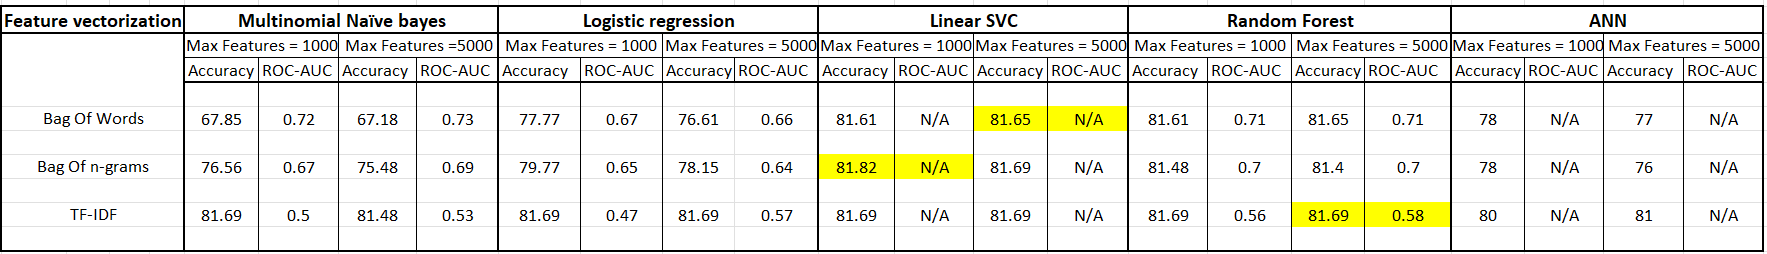







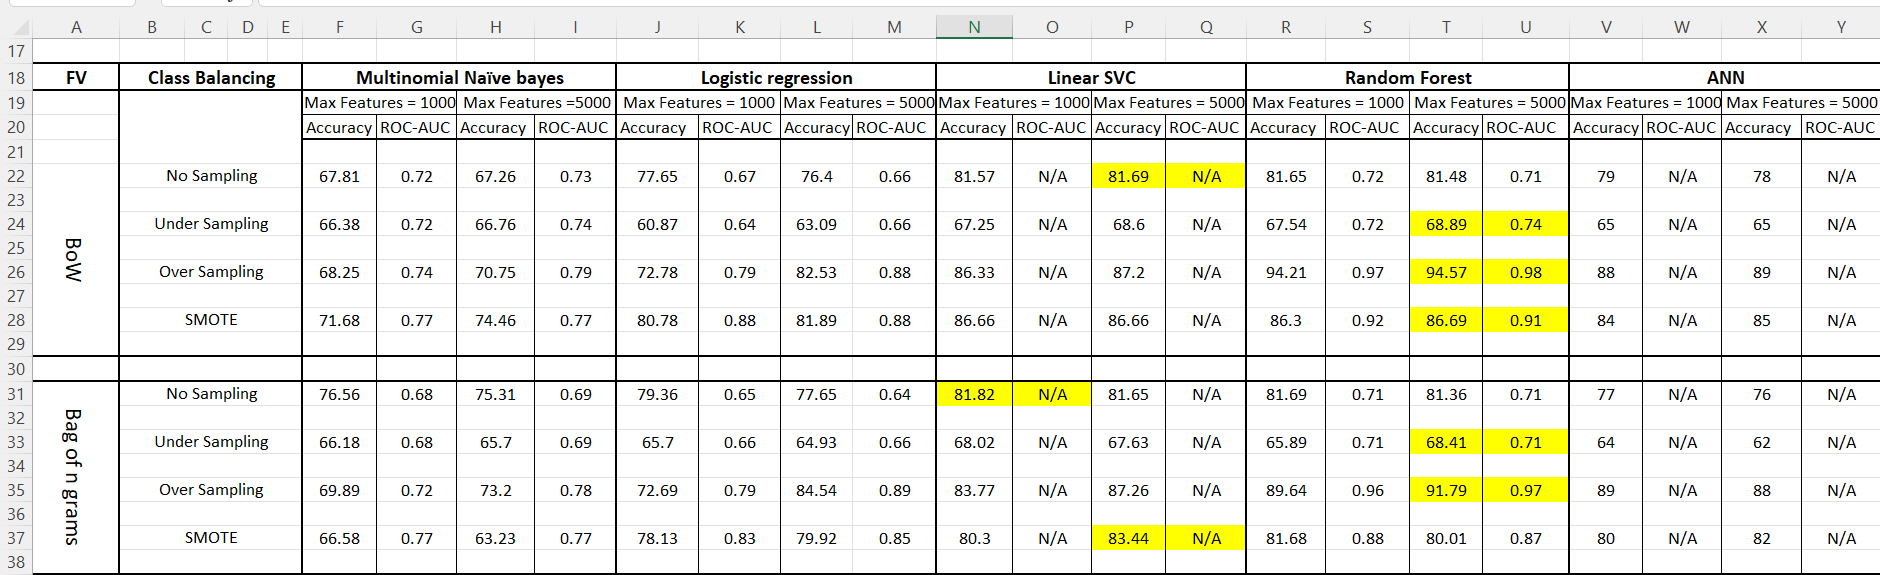
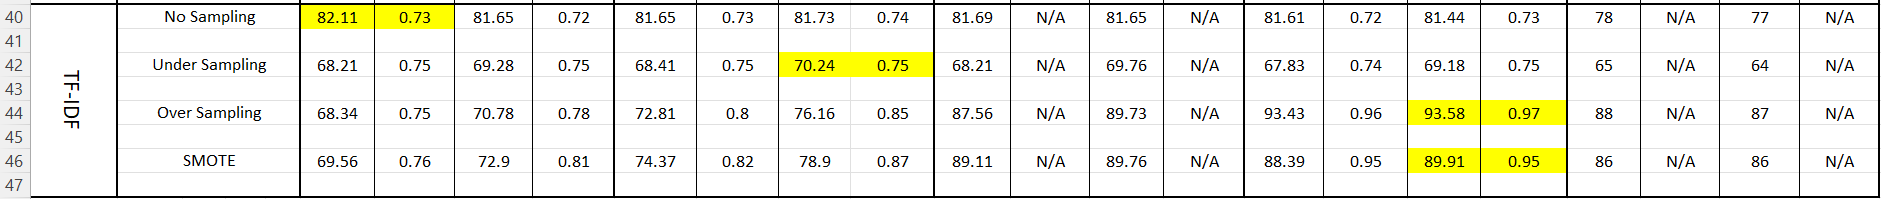

# For the first task we can observe that, Linear SVM performs better for Bow and Bag of n grams as comapred to other models. For Tf-Idf almost all models give identical results but Random Forest or ANN can be preferred as they can be more finetuned easily and better results can be achieved from them. 

For the second task, we can observe that: 

*   Bow (Oversampling) with Random Forest 
*   Bag of n gram (Oversampling) with Random Forest
*   TF-IDF (Oversampling) with Random Forest       

these above combinations give the best result.

When we vectorize the training data, the CountVectorizer will select the words/features/terms which occur the most frequently. It takes absolute values so if you set the 'max_features = 5000', it will select the 5000 most common words in the data. The best way to omit the word from the given corpus/data, of course, would be to use stop_words parameter, but imagine if there are plenty of such words; or words that are related to the topic but occur scarcely. In the second case, the max_features parameter will help.  
We can observe from the excel table that, for our particular dataset, for the normal Bow, bag of n grams and TF-IDF cases, we get better accuracy when we used 'max_features = 1000'. This shows that 1000 is a better value for 'max_features' making feature vector for all the 3 types and hence means there are only around 1000 common and related words to our news headline. Increasing or decreasing the max_feature by 30-40% might yield even better results. 


Whereas for under,over sampling and SMOTE we get better results for 'max_features = 5000' because these methods change the size of data by removing samples (undersampling) or adding samples (oversampling&SMOTE) and this results in more number of common words higher than 1000 and hence it yields better results for 'max_features = 5000'.

**Overall, for classifying news headline as to be relevant or non relevant we can use Bow (Oversampling) with Random Forest model as it gives the highest accuracy of 94.57**

SMOTE overall performs well and matches close to oversampling.                                             
Undersampling, reduces the accuracy by a lot hence it is not normally preferred method of class balancing.

Undersampling involves randomly removing examples from the majority class.     
Oversampling involves randomly duplicating examples from the minority class and adding them to the minority class.                
SMOTE involves randomly synthesizing examples from the minority class and adding the new synthesized examples to the minority class.